## Audio Test Notebook 

This notebook demonstrates essential Audio I/O utilities provided in the **pyspch.audio** module
- loading audio data from file   
- play audio
- record audio and set device properties
    + in colab recording is supported via the browser (javascript)

Date: 11/04/2021, 13/05/2021, 24/05/21, 08/02/22, 21/02/22   
Last Verified: 01/04/2022

In [1]:
# optional install of the pyspch package
#!pip install git+https://github.com/compi1234/pyspch.git

In [3]:
%matplotlib inline
from IPython.display import display, clear_output, Audio, HTML
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

import librosa
try:
  import google.colab
  IN_COLAB = True 
  ! pip install git+https://github.com/compi1234/pyspch.git
except:
  IN_COLAB = False

# verify the IPython version
import IPython
if IPython.version_info[0] >= 6:
    Audio_args = {'normalize':False}
else:
    print("Warning: you are using IPython<6 \n IPython.display.Audio() will automatically normalize audio output")
    Audio_args = {}
import pyspch.core as Spch
import pyspch.sp as Sps
import pyspch.display as Spd

SAMPLE_WAV_URL = 'https://homes.esat.kuleuven.be/~spchlab/data/misc/train.wav'
SAMPLE_WAV_13dB_SNGER = 'https://homes.esat.kuleuven.be/~spchlab/data/13dB/Psnger22.wav'
TIMIT_WAV_URL = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/test/dr1/faks0/si2203.wav'

## 1. Your (local) Sound Device - querying & setting basic properties

Your sounddevice gets accessed via the [sounddevice](https://pypi.org/project/sounddevice/) package.  Sounddevice mainly provides bindings to the [PortAudio](http://www.portaudio.com/) cross platform C-libarry.

Sounddevice properties are either common for input/output or specified as a list [ input, output ]  
Hardware information and Factory settings are accessible via soundevice.qeury_devices() and souddevice.hostapis().  
Current settings are given in souddevice.default object   
Checking if your input or output devices can handle a request can be done via sounddevice.check_input_settings()

For speech processing you may want to set 
- sounddevice.default.samplerate = 16000    (applied to both input and output)
- sounddevice.default.channels = 1          (you can set different values for input,output )

In [4]:
# Hardware info and factory settings, defaults
import sounddevice as sd
print("Available Devices and Core Audio Libraries on your machince:\n"+"+"*70)
print("Sounddevice: ",sd.__version__)
print("PortAudio: ", sd.get_portaudio_version())
print("Available Devices: "); print(sd.query_devices())
print("Factory Defaults:",sd.query_hostapis())
#
sd.default.samplerate = 16000
sd.default.channels = 1, 1
print("\n\nSettings for Current Devices: input=%d, output=%d " %(sd.default.device[0],sd.default.device[1]))
print("+"*50)
#print("Devices: ", sd.default.device)
print("Factory default settings on input device: ")
print(sd.query_devices(sd.default.device[0]))
print("Factory default settings on output device:")
print(sd.query_devices(sd.default.device[1]))
print("\nDefault Settings (if None ==> factory)")
print("   Number of Channels: ",sd.default.channels)
print("   Sampling Rate: ",sd.default.samplerate)
print("   dtype: ",sd.default.dtype)

Available Devices and Core Audio Libraries on your machince:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Sounddevice:  0.4.3
PortAudio:  (1246976, 'PortAudio V19.7.0-devel, revision 147dd722548358763a8b649b3e4b41dfffbcfbb6')
Available Devices: 
   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone Array (2- Intel® Sma, MME (2 in, 0 out)
   2 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  3 Speakers (Realtek(R) Audio), MME (0 in, 2 out)
   4 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   5 Microphone Array (2- Intel® Smart Sound Technology (Intel® SST)), Windows DirectSound (2 in, 0 out)
   6 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
   7 Speakers (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
   8 Speakers (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
   9 Microphone Array (2- Intel® Smart Sound Technology (Intel® SST)), Windows WASAPI (4 in, 0 out)
  10 Microphone Array (Intel® Smart Sound T

## 2. Reading Audio from file

With **Spch.load()** you can read from *url* or from *file*.  It is a wrapper around librosa.load() allowing for both types of input.   librosa uses the python package [soundfile](https://pypi.org/project/SoundFile/) under the hood, which in turn uses the C-library [libsndfile](http://www.mega-nerd.com/libsndfile/).

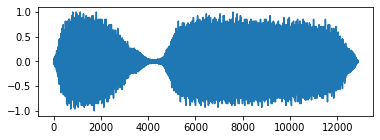

In [5]:
# help(Spch.load)
#
wavname = SAMPLE_WAV_URL
#wavname = TIMIT_WAV_URL
wavdata,sample_rate= Spch.load(wavname) 
# print(wavdata.shape, sample_rate)
fig = plt.figure(figsize=(6,2))
plt.plot(wavdata)
# if you prefer the plot above the audio widget, then flush the plot by adding the line below
# plt.show()
display(Audio(data=wavdata,rate=sample_rate,autoplay=False,**Audio_args))

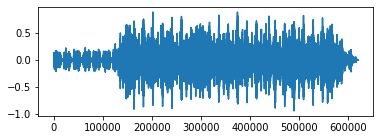

Original Data:  (619982,) 22050


Resampled Data:  (449874,) 16000


In [6]:
# You can specify a new sampling rate when reading in the data or convert multi to mono
# -- sample_rate=16000
# -- mono=True
wavname = SAMPLE_WAV_13dB_SNGER
# wavname = SAMPLE_WAV_URL
wavdata,sample_rate= Spch.load(wavname)
wavdata_16k,sample_rate_16k= Spch.load(wavname,sample_rate=16000)
fig = plt.figure(figsize=(6,2))
plt.plot(wavdata)
plt.show()
print("Original Data: ",wavdata.shape, sample_rate)
display(Audio(data=wavdata,rate=sample_rate,autoplay=False,**Audio_args))
print("Resampled Data: ",wavdata_16k.shape, sample_rate_16k)
display(Audio(data=wavdata_16k,rate=sample_rate_16k,autoplay=False,**Audio_args))

## 3. Record from device

With **Spch.record()** you can record from your local device and in Colab via the webbrowser.
You can set sampling rate and number of channels to be recorded, but check to see if the requested number of
channels is available

In [7]:
# help(Spch.record)
#
requested_channels = 2
try:
    sd.check_input_settings(device=sd.default.device[0],channels=requested_channels)
    print("OK: number of requested channels is available")
except:
    print("Warning: requested number of input channels %d not available; change your request "
          % (requested_channels) )
    requested_channels = 1
sample_rate=16000
wavdata = Spch.record(3.,sample_rate,n_channels=requested_channels)
print(wavdata.shape)

OK: number of requested channels is available
recording started for 3.00 seconds on 2 channel(s)
recording finished
(2, 48000)


In [8]:
# Remark that the IPython Audio object BY DEFAULT NORMALIZES the output
# The default **Audio_args will overcome that in versions of IPython (>=6) where normalization can be turned off
# Be careful, however, as the Audio module will crash on values exceeding +-1, there is no autoclipping
# Google Colab uses IPython 5.5 !!
# Record something in a soft voice and play both versions below for clear demonstration
if IPython.version_info[0] >= 6:
    print("Autonormalize when playing is OFF")
    display(Audio(data=wavdata,rate=sample_rate,normalize=False))
    print("Autonormalize when playing is ON")
    display(Audio(data=wavdata,rate=sample_rate,normalize=True))
else:
    print("Warning: in IPython <6 you can only play normalized audio via the Browser !!")
    display(Audio(data=wavdata,rate=sample_rate))

Autonormalize when playing is OFF


Autonormalize when playing is ON


## 4. Multichannel plot and play

**Spd.PlotWaveform()** plots mono and multichannel waveforms.

**Spch.play()** plays the audio directly without displaying an interactive HTML control.  
- in Colab an HTML Audio control will be displayed anyhow
- note that the HTML Audio control maximally allows for 2 channels 

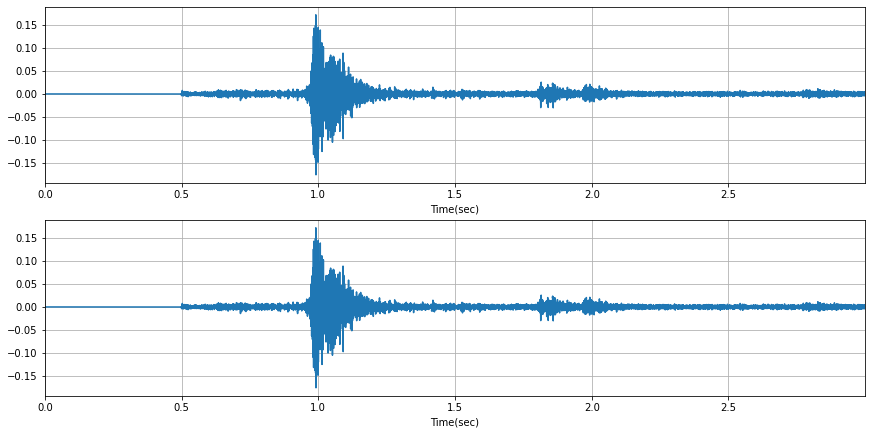

In [9]:
Spd.PlotWaveform(wavdata,sample_rate=sample_rate)

In [10]:
# just play the (stereo) waveform
# if you want to stage multiple sequential plays in a cell (or python code), 
# then you must wait for each of them to finish before starting the next one

# This will play all channels and wait for audio to finish
Spch.play(wavdata,sample_rate=sample_rate,wait=True)

# This plays channel=0 and returns immediately 
Spch.play(wavdata,sample_rate=sample_rate,channels=[0])